# Classifying Whether Satellite Images Have Airplanes or Not?
### - Darshil Desai

In this project I will employ the use of Convolutional Neural Networks (using Keras) to create a model that classifies whether a satellite image contains airplanes or not. The dataset is sourced from  [Kaggle](https://www.kaggle.com/rhammell/planesnet) and comprises of features being images (falattened our into nxn rows of each feature being a pixel value) and output labels<br>

Thanks for reading!
<br>

#### Other References: 
[Other Clustering Project](https://medium.com/@h4k1m0u/clustering-a-satellite-image-with-scikit-learn-14adb2ca3790) <br>
[Image Source](https://developers.planet.com/planetschool/)

In [32]:
#----------data preprocessing-------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#------Neural Networks-----------
import keras
from keras import regularizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

### Data Preprocessing

Before we move on to crafting the CNN architecture we need to "create" usable data from the image data we have. Briefly preprocessing will involve: 

- 1) Reading in the dataset
- 2) Viewing an image to confirm its read in correctly
- 3) Converting our "data" column (to size 1x1200, 400 RGB each) into a dataframe of size 32000x1200 wherein 32K represents the number of images 
- 4) UNIFORMLY resize and create new data out of dataframe and convert dataframe to numpy array of size num_datax20x20x3 
- 5) Split into training and testing followed by one-hot coding the labels
- 6) Train the model without data augmentation
- 7) Training the model using data augmentation. Here we artificially create expand our existing dataset by slightly modifying existing images to create new training data

### (1) Reading in data

In [5]:
"""
1. Reading in Json file
"""
data_df = pd.read_json('planesnet.json')

#lets take a look at our data
data_df.head()

,data,labels,locations,scene_ids
0,"[206, 195, 187, 183, 177, 175, 174, 193, 198, ...",1,"[-118.40497658522878, 33.940618514147936]",20170620_175442_0e30
1,"[215, 209, 200, 196, 192, 197, 205, 168, 155, ...",1,"[-122.392469714, 37.6176425378]",20161212_180859_0e30
2,"[204, 214, 220, 219, 213, 205, 198, 193, 199, ...",1,"[-122.397578597, 37.6209247852]",20170524_181349_0e2f
3,"[179, 174, 179, 178, 173, 170, 168, 168, 168, ...",1,"[-122.214849831, 37.7203378331]",20161110_180707_0e1f
4,"[222, 222, 218, 214, 208, 205, 207, 206, 206, ...",1,"[-117.862173435, 33.6796854072]",20160813_184932_0c64


In [ ]:
""" 
Lets take a look at dataframe data_df
-----------------------------

- Data  : a list of 1200 pixel values of each image
- labels : 0 or 1 for plane or no-plane in the image
Everything else is redundant
"""

### (2) Viewing the image

We'll go ahead and view the image in its full size (comprising 1200 pixels). To the human eye this highly pixelated image is meaningless! 

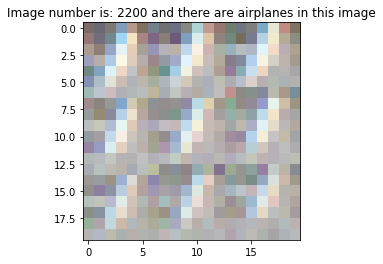

In [20]:
#Lets take a look at the image!

image_num = 2200
a = np.array(data_df.iloc[image_num,0]).reshape(20,20,3)
plt.imshow(a)

if data_df.iloc[image_num,1] == 1:
    plt.title('Image number is: {} and there are airplanes in this image'.format(image_num))
else:
    plt.title('Image number is: {} and there are NO airplanes in this image'.format(image_num))
    


### (3) Combining all image vectors into a dataframe along with the correct class

In [22]:
"""
3. Pandas series to dataframe and then we need to randomly shuffle 
(https://stackoverflow.com/questions/45901018/convert-pandas-series-of-lists-to-dataframe)

We're also going to add the label column to our pixel_df
"""
#Now we're going to transpose 
pixel_df = pd.DataFrame.from_items(zip(data_df['data'].index, data_df['data'].values)).T

#adding the label column
pixel_df['labels'] = data_df['labels']
pixel_df.head()

print ('Size of this dataframe: {}'.format(pixel_df.shape[0] ))

Size of this dataframe: 32000


### (4) Uniformly distributing our dataset

In [23]:
"""
Convert Pandas dataframe of size 32000x1200 to numpy array of size 32Kx1200
NOTE! We need to reshape our data to size number_of_datapoints x 20x20x3 where 20x20x3 are the dimensions 
..for each colored image

Furthermore, its important to understand that because the labels in our dataset are not uniform, ie: there are 24K images 
...with no planes and only 8K images with planes in them, it is important to uniformly distribute the data to train on
"""


#------------creating a uniform dataset-------------

#random seed
random.seed(2)
#We create a new dataframe that we will append to 
new_df = pd.DataFrame(index=[0], columns=pixel_df.columns)
new_df = new_df.fillna(0)

#determine size of dataset (can go max 8K for label==1)
size_dataset = 16000

for x in list(set(pixel_df['labels'])):
    
    #first we subset the datatframe
    a = pixel_df[pixel_df['labels']==x]
    
    #randomly choose N/2 indices
    rands = random.sample(list(a.index),int(size_dataset/2))
    
    #pick the indices
    b = a.loc[rands] 
    
    #append to existing dataframe 
    new_df = pd.concat([new_df,b])
    
    #dropping first row which was just initialized to 0
    new_df = new_df.iloc[1:,:].dropna(axis=0)
    
#RANDOMLY SHUFFLE AGAIN
rands1 = random.sample(list(new_df.index),size_dataset-1)
new_df = new_df.loc[rands1]
        
print ('Confirming that our dataset is uniformly distributed', '\n', 
       '--------------------------')
print (new_df['labels'].value_counts(dropna=False))

shuffled_pixel_df= new_df

Confirming that our dataset is uniformly distributed 
 --------------------------
1    8000
0    7999
Name: labels, dtype: int64


### (5) Split dataset into training and test

In [24]:
#---determine training and test data sizes-----
training_size = int(0.95 * size_dataset)

#-----training data-----
training_data = np.array(shuffled_pixel_df.iloc[0:training_size,:1200])
training_data_labels = np.array(pd.get_dummies(shuffled_pixel_df.iloc[0:training_size,1200]))  #one-hot coding and then converting to numpy
print ('Size of training data: ',training_data.shape[0], '\n',
      'Size of training data labels: ',training_data_labels.shape[0] , '\n \n')

#-----test data-----
test_data = np.array(shuffled_pixel_df.iloc[training_size:,:1200])
test_data_labels = np.array(pd.get_dummies(shuffled_pixel_df.iloc[training_size:,1200]))
print ('Size of test data: ',test_data.shape[0], '\n',
      'Size of test data labels: ',test_data_labels.shape[0] )


print ('Confirming that the training and test data sizes equal to total size of dataset: ', training_data.shape[0] + test_data.shape[0])



#reshaping our training and test data HERE!
training_pixel_np = training_data.reshape(training_size,20,20,3)
test_pixel_np = test_data.reshape(test_data.shape[0],20,20,3)

Size of training data:  15200 
 Size of training data labels:  15200 
 

Size of test data:  799 
 Size of test data labels:  799
Confirming that the training and test data sizes equal to total size of dataset:  15999


In [25]:
print ('Training data shape after reshaping: ', training_pixel_np.shape,'\n',
'Test data shape after reshaping: ', test_pixel_np.shape)

Training data shape after reshaping:  (15200, 20, 20, 3) 
 Test data shape after reshaping:  (799, 20, 20, 3)


## (6)Training the model without Data Augmentation

In [112]:
model = Sequential()

model.add(Conv2D(64,kernel_size=(3,3), activation='relu', input_shape = (20,20,3),kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3), activation='relu', input_shape = (20,20,3),kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation = 'softmax'))

In [113]:

#print out model summary
model.summary()

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 18, 18, 64)        1792      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 1152)              0         
__________

In [114]:
num_epochs = 10

history = model.fit(training_pixel_np,training_data_labels,
                   batch_size = 200,
                   epochs=num_epochs,
                   verbose=0,
                   validation_data = (test_pixel_np, test_data_labels))

### Plotting Training Accuracies & Loss

Text(0.5,1,'Training Loss')

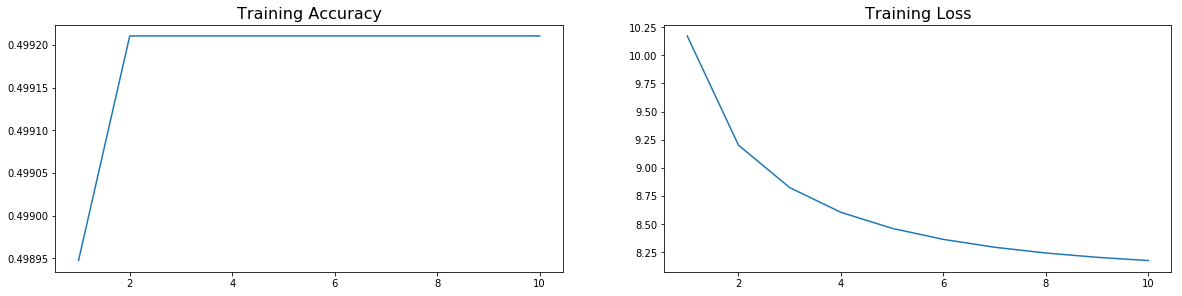

In [115]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot( range(1,num_epochs+1),history.history['acc'])
plt.title('Training Accuracy', fontsize=16)

plt.subplot(2,2,2)
plt.plot( range(1,num_epochs+1),history.history['loss'])
plt.title('Training Loss', fontsize=16)

### Plotting Validation Data Accuracies & Loss

Text(0.5,1,'Validation Loss')

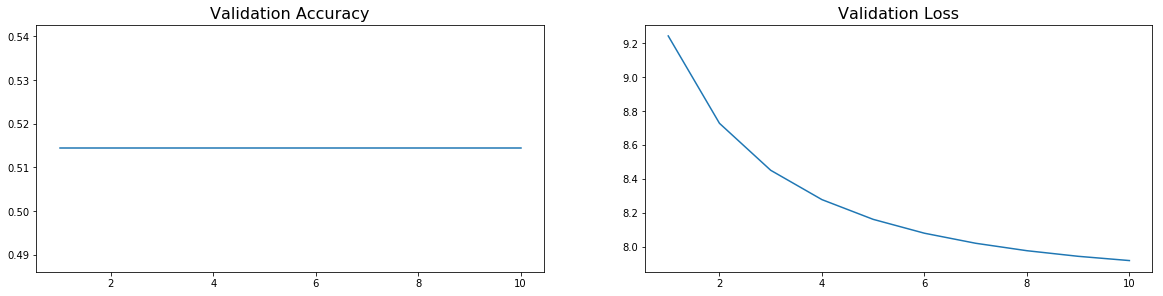

In [116]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot( range(1,11),history.history['val_acc'])
plt.title('Validation Accuracy', fontsize=16)

plt.subplot(2,2,2)
plt.plot( range(1,11),history.history['val_loss'])
plt.title('Validation Loss', fontsize=16)

### Using the model to predict whether an images has airplanes or not

The model predicts there are NO airplanes in this image. The actual classification : Yes planes


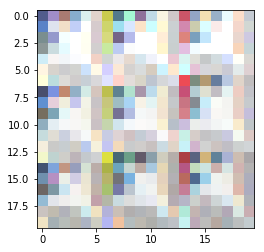

In [127]:
a = np.array(training_pixel_np[1:2]).reshape(20,20,3)
plt.imshow(a)

#---------------
preds = model.predict_classes(training_pixel_np[1:2])



if training_data_labels[1:2][0][1] == 1:
    actual = ': Yes planes'
else: 
    actual = ': No planes'


if preds[0] == 0:
    print ('The model predicts there are NO airplanes in this image. The actual classification {}'.format(actual))
else:
    print ('The model predicts that there ARE airplanes in this image. The actual classification {}'.format(actual))

    
    
    

In [128]:
#lets take random images and predict
preds = model.predict(training_pixel_np[1:10])

np.round(preds)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## (7) Neural Network:  Model Using Data Augmentation

In this case we will apply the same convolutional neural network architecture but by using a much larger training dataset

In [129]:
model = Sequential()

model.add(Conv2D(64,kernel_size=(3,3), activation='relu', input_shape = (20,20,3),kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3), activation='relu', input_shape = (20,20,3),kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation = 'softmax'))
#print out model summary
model.summary()

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 18, 18, 64)        1792      
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1152)              0         
__________

In [130]:
image_gen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,   #rotate images
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)   #flip horizontally

#training the image preprocessing
image_gen.fit(training_pixel_np, augment=True)

In [131]:
"""
HOW DATA AUGMENTATION WORKS?
Data augmentation works as follows: at each learning epoch transformations with randomly 
selected parameters within the specified range are applied to all original images in the training set. 
After an epoch is completed, i.e. after having exposed a learning algorithm to the entire set of training data, 
the next learning epoch is started and training data is once again augmented by applying specified transformations 
to the original training data.

Important parameters: 
batch_size = selected batch of training data fed to NN
steps_per_epoch = batch size forward and back propogated this many times for each epoch. 
   ...I think this number = number of augmented images for each image


"""
num_epochs  = 10

model.fit_generator(image_gen.flow(training_pixel_np, training_data_labels, batch_size=200),           
          steps_per_epoch = training_pixel_np.shape[0]/32,
          epochs=num_epochs,
          verbose=0,
          validation_data = (test_pixel_np, test_data_labels))

### Plotting Training Accuracies & Loss

Text(0.5,1,'Training Loss')

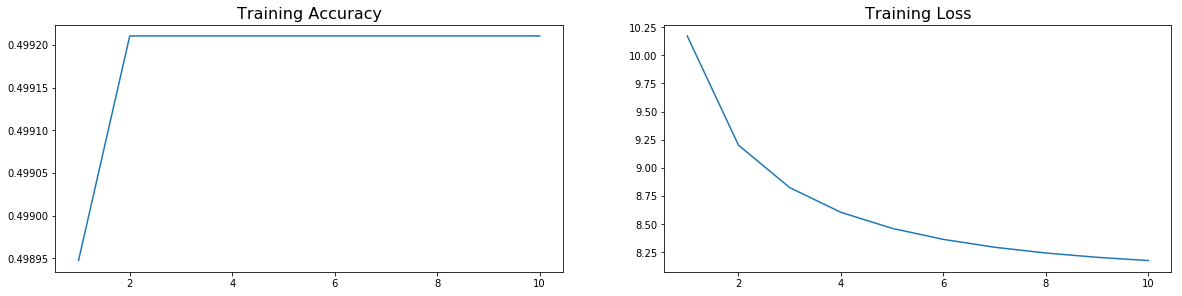

In [132]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot( range(1,num_epochs+1),history.history['acc'])
plt.title('Training Accuracy', fontsize=16)

plt.subplot(2,2,2)
plt.plot( range(1,num_epochs+1),history.history['loss'])
plt.title('Training Loss', fontsize=16)

### Plotting Validation Data Accuracies & Loss

Text(0.5,1,'Validation Loss')

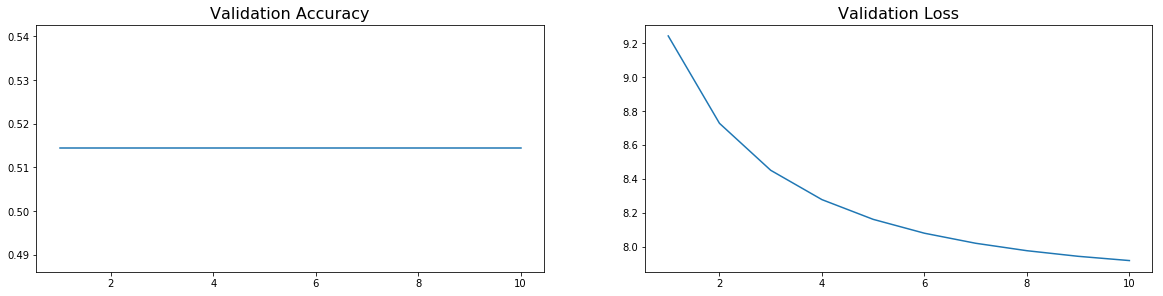

In [133]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot( range(1,11),history.history['val_acc'])
plt.title('Validation Accuracy', fontsize=16)

plt.subplot(2,2,2)
plt.plot( range(1,11),history.history['val_loss'])
plt.title('Validation Loss', fontsize=16)

The training and validation accuracy and loss results prove to be quite perplexing! The loss seems to decrease but the accuracy remains the same and unchanged. 

I believe such a phenomenon occurs when minimizing a binary cross-entropy loss if the predicted value (normalized into probabilities) for the correct label might increase gradually lets say from 0.2 to 0.3 to 0.38 but not crossing the classification threshold of 0.5. In this case we could argue that the model loss is indeed improving but that improvement can be rendered useless when using it to classify. 

Furthermore the model architecture is very basic due to limited computational resources on my end (Fun fact: I began training the model, went grocery shopping, came back to find it running for 10 epochs..) but I'm sure increased number of layers would be the first step in improving model results. 

### Using the model to predict whether an images has airplanes or not

The model predicts that there ARE airplanes in this image


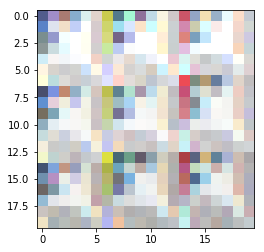

In [134]:
a = np.array(training_pixel_np[1:2]).reshape(20,20,3)
plt.imshow(a)

preds = model.predict_classes(training_pixel_np[1:2])

if preds[0] == 0:
    print ('The model predicts there are NO airplanes in this image')
else:
    print ('The model predicts that there ARE airplanes in this image')
    

In [ ]:
#lets take random images and predict
a = model.predict(training_pixel_np[1:15])
np.round(a)

### Conclusion



The CNN architectures used in this project yield poor results. This of course is partly because of limiting the network architecture to small sizes in the interest of saving a lot of training time on my local computer. My goal for this project was to learn how to wrangle image data into usable training data and play around with the CNN architecture. 

I hope you like the project thanks again for reading!